In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


# Part 1 - DEFINE

---  Defining the problem  ---

The goal of this project is to predict the sale price of houses in the test data set based on the data given in the train data set.

The data used has 81 features which includes 38 numeric features and 43 categoric features. Th tool used is python 3 along with its libraries and packages

In [2]:
#my info
__author__ = "Ahsana Ahffan"
__email__ = "ahsanahf@gmail.com"

In [3]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Part 2 - DISCOVER

In [4]:
#load files
df_train=pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
df_test=pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

In [5]:
#Save a copy of train and test dataframes
train_df=df_train.copy()
test_df=df_test.copy()

In [6]:
test_df.shape

(1459, 80)

In [7]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
df_train.describe(include=np.number)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
df_train.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


## Explore the data (EDA)

### Visualising Target variable

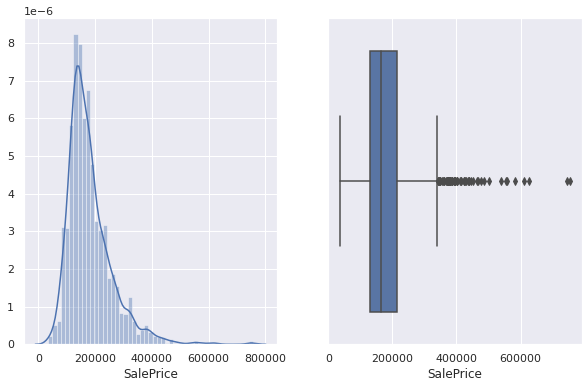

In [11]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.distplot(df_train['SalePrice'])
plt.subplot(1,2,2)
sns.boxplot(df_train['SalePrice'])

From the above plots of target variable we can see some potential outliers

In [12]:
#Use 1.5 IQR rule to find outliers
stat=df_train.SalePrice.describe()
print(stat)
IQR=stat['75%'] - stat['25%']
upper=stat['75%'] + 1.5*IQR
lower=stat['25%'] - 1.5*IQR
print("Upper and lower bound of suspected outliers are {} and {}.".format(upper,lower))

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Upper and lower bound of suspected outliers are 340037.5 and 3937.5.


In [13]:
print(df_train[df_train.SalePrice < 3937.5])

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

[0 rows x 81 columns]


In [14]:
df_train[df_train.SalePrice > 340037.5].count().max()

61

From the above data we can infer that 61 entries out of 1460 entries has SalePrice above upper bound. Also we can see from the boxplot of target variable that most of these suspected outliers are with salprice less 500000 which we can consider normal. Also from the boxplot we can see 2 entries with saleprice greater than 700000 which makes them the most dangerous outliers. But when we carefully examine the the scatter plots of numerical features v/s the target variable we can see that the entries with saleprice above 700000 have top features. So for now we can keep them.

### Correlation between numerical features

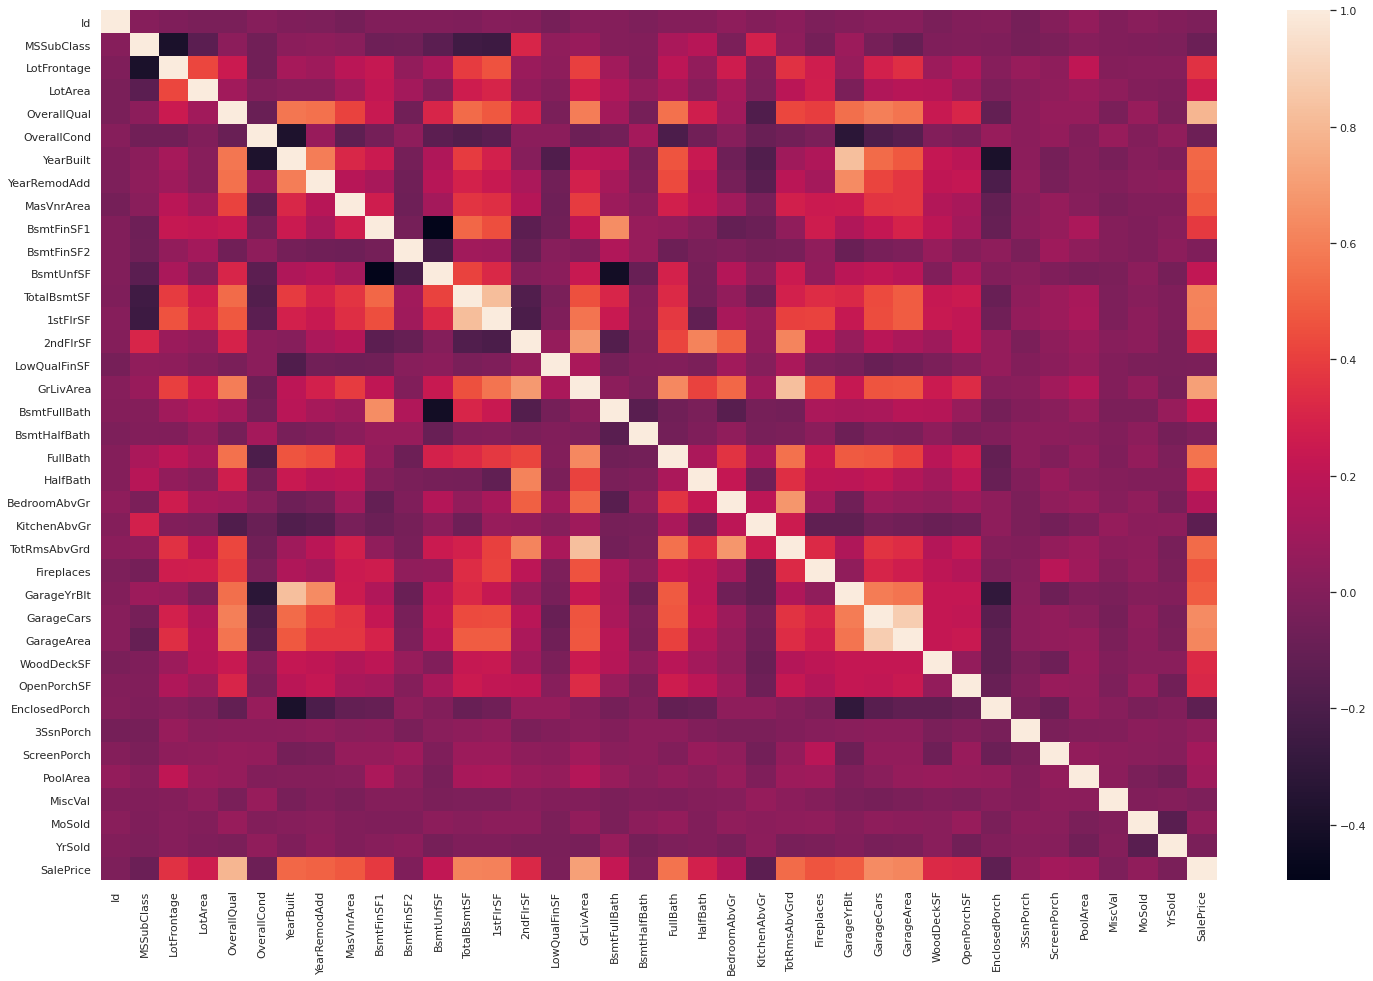

In [15]:
plt.figure(figsize=(25,16))
corr=df_train.corr()
sns.heatmap(corr)

Inferences from the above heatmap are:

1.The feature 'OverallQual' has the highest correlation with the target variable 'SalePrice' followed by the features'GrLivArea', 'GarageCars', 'GarageArea', 'FullBath', 'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'
2. Features TotalBsmtSF and 1stFlrSF has very high correlation
3. Similarly and obviously GarageCars and GarageArea are very much correlated.


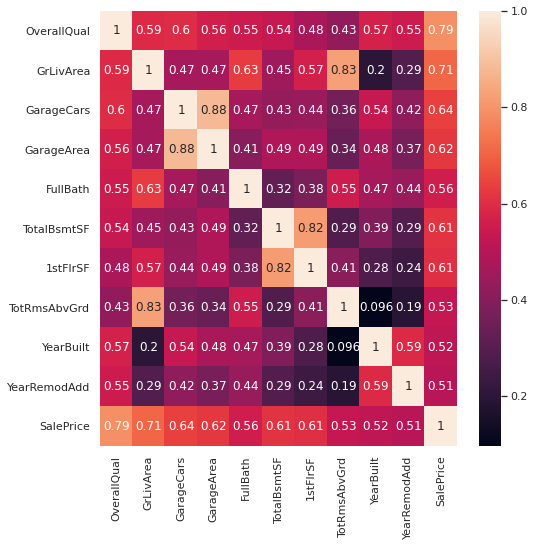

In [16]:
#Plotting heatmap with features that are highly correlated with the target variable
cols=['OverallQual', 'GrLivArea','GarageCars','GarageArea','FullBath','TotalBsmtSF','1stFlrSF','TotRmsAbvGrd',
      'YearBuilt', 'YearRemodAdd','SalePrice']
plt.figure(figsize=(8,8))
cor=df_train[cols].corr()
sns.heatmap(cor,annot=True)

Since the features 'GarageCars' and 'GarageArea' are highly correlated we can consider only 'GarageCars' and similarly consider TotalBsmtSF only due to high collinearity of TotalBsmtSF with 1stFlrSF and 'RmsAbvGrd' 

### Correlation between numerical features and the target variable

In [17]:
#Define function to plot correlation
def num_cor(col,df):
    sns.scatterplot(x=col,y=df_train['SalePrice'],data=df)

def cat_cor(col,df):
        plt.figure(figsize=(10,6))
        sns.barplot(x=col,y=df_train['SalePrice'],data=df)

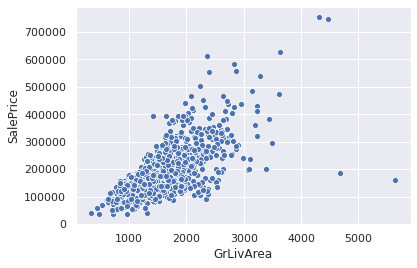

In [18]:
num_cor('GrLivArea',df_train)

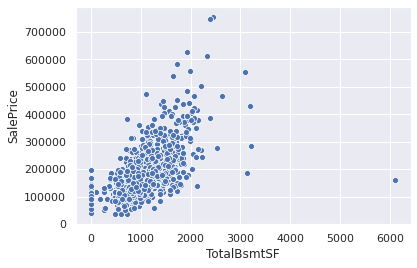

In [19]:
num_cor('TotalBsmtSF',df_train)

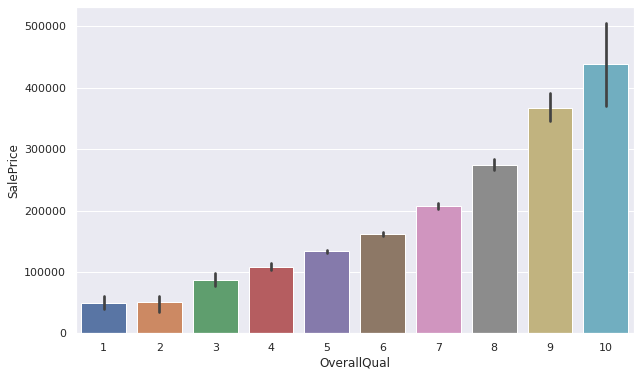

In [20]:
cat_cor('OverallQual',df_train)

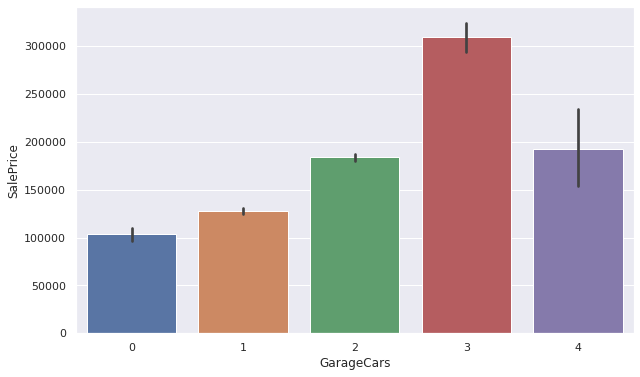

In [21]:
cat_cor('GarageCars',df_train)

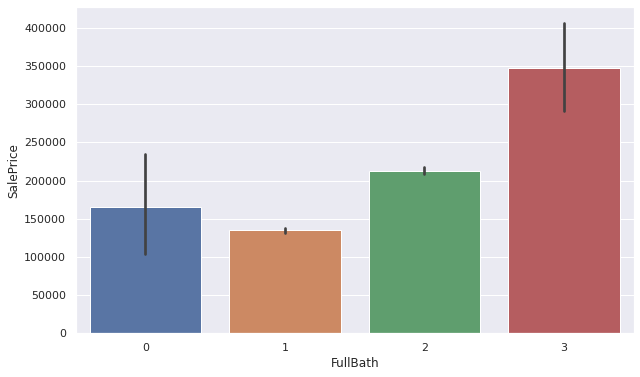

In [22]:
cat_cor('FullBath',df_train)

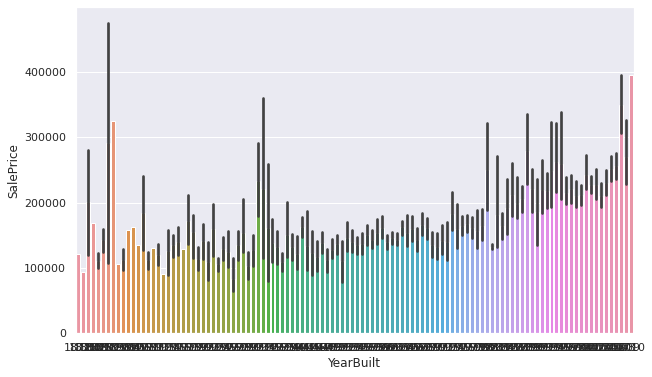

In [23]:
cat_cor('YearBuilt',df_train)

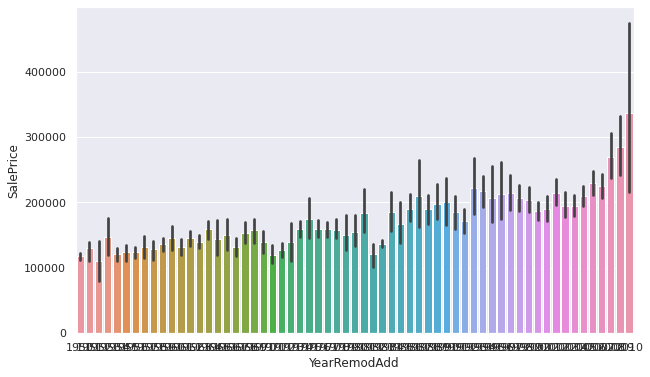

In [24]:
cat_cor('YearRemodAdd',df_train)

### Correlation between Categorical features and Target variable

In [25]:
column=df_train.select_dtypes(include=[np.float64,np.object]).columns
listcol=list(column)
len(listcol)

46

In [26]:
def cat_box(col,df):
    mean=df_train.groupby([col])['SalePrice'].mean().sort_values(ascending=True).index
    sns.boxplot(x=col,y='SalePrice',data=df,order=mean)
    plt.xlabel(col)
    plt.ylabel("Mean SalePrice")
    plt.title(" "+col)
    

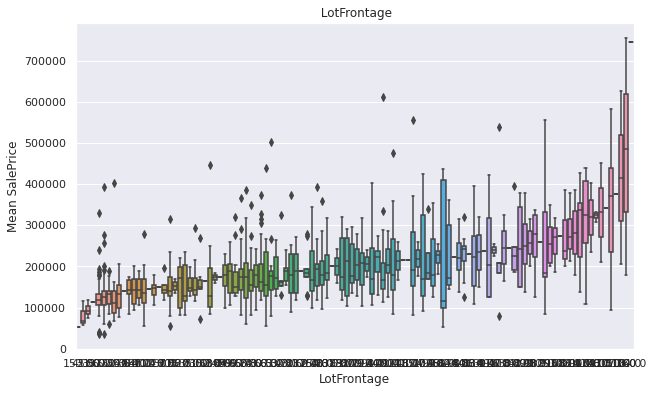

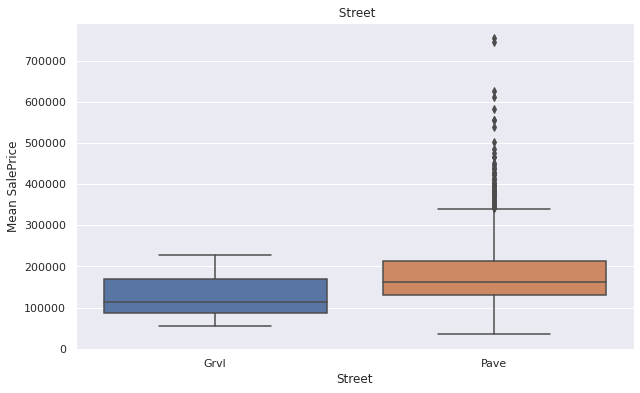

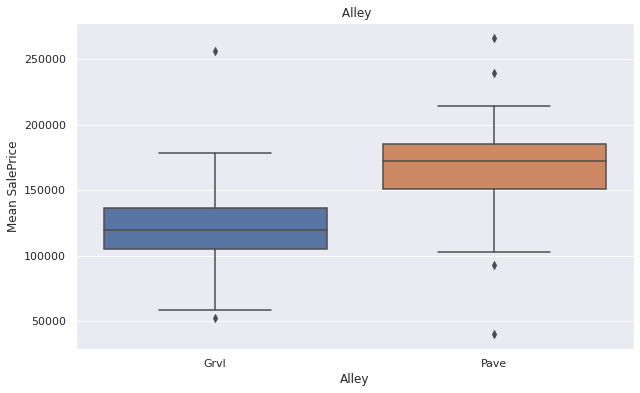

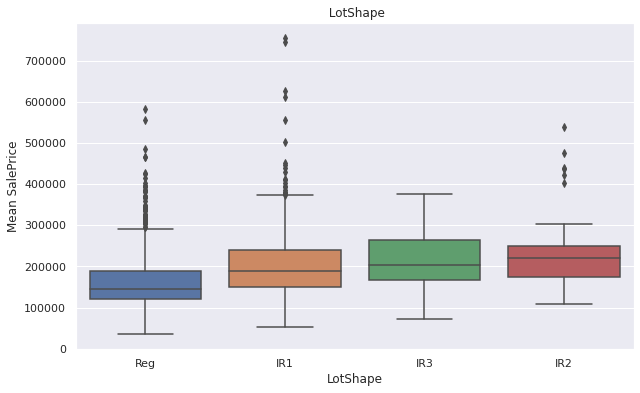

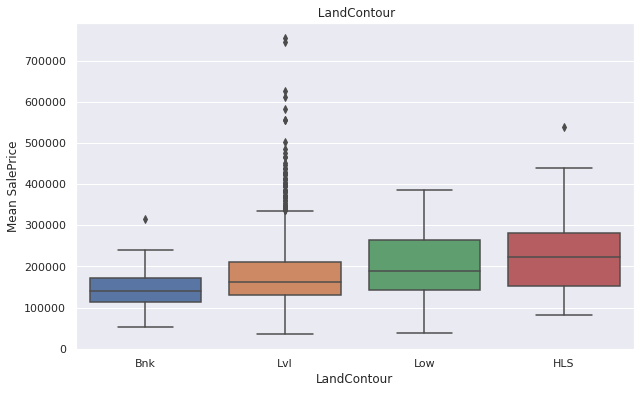

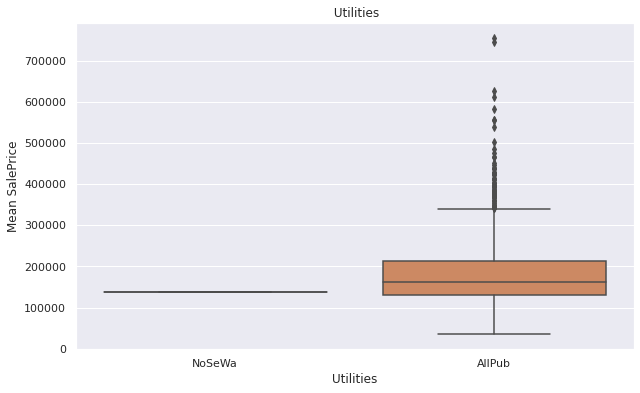

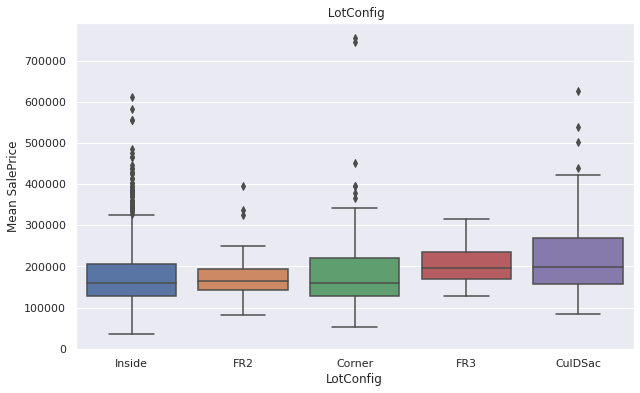

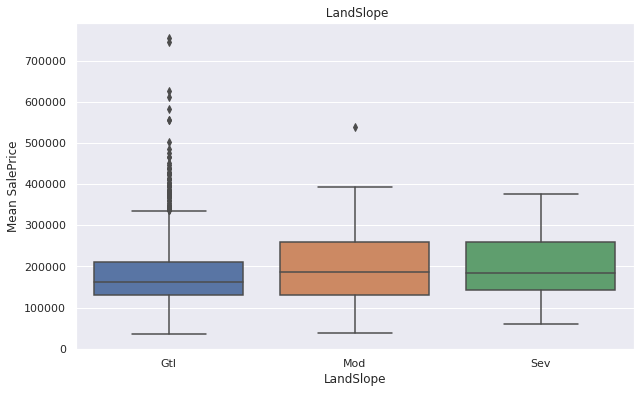

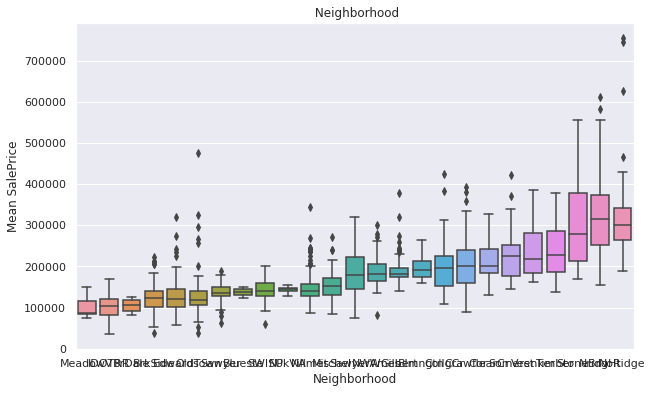

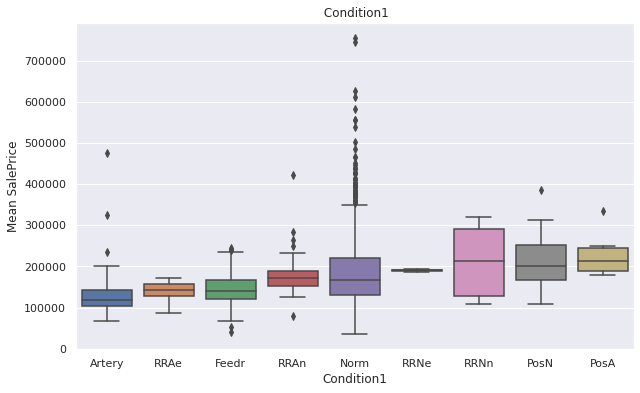

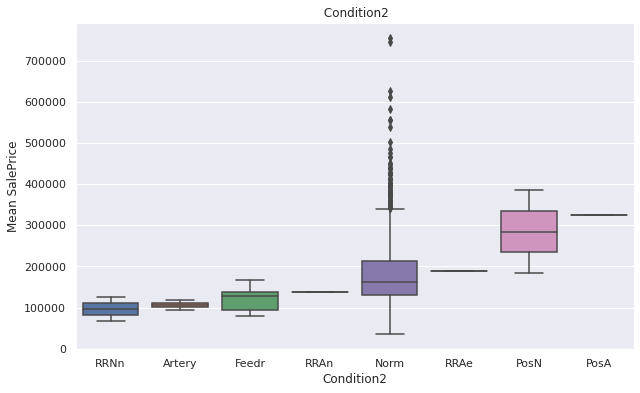

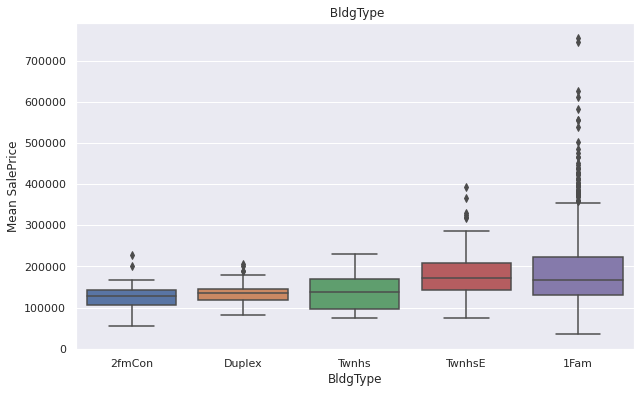

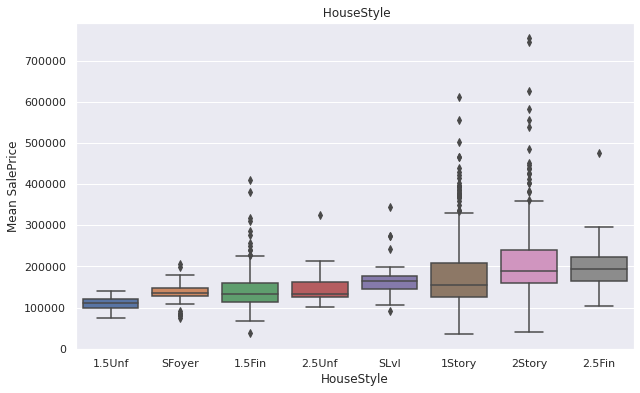

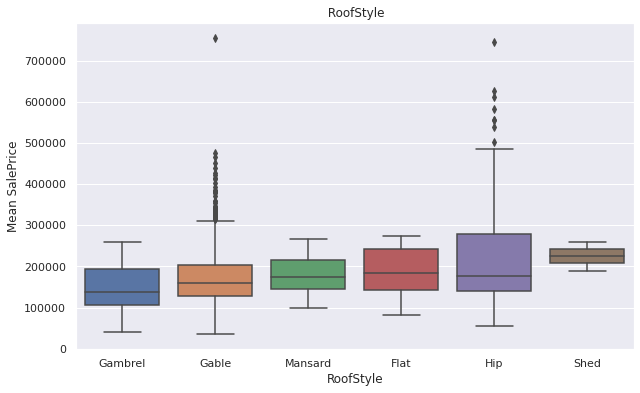

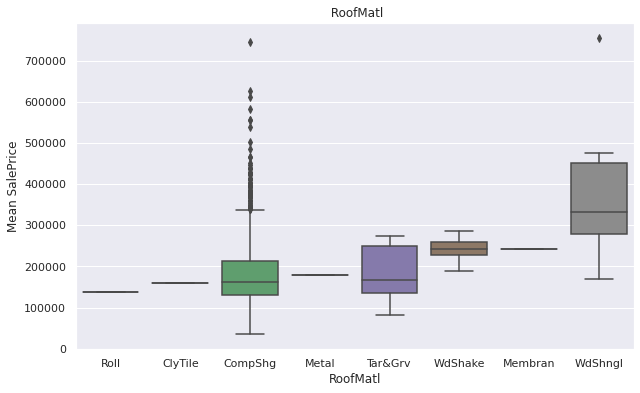

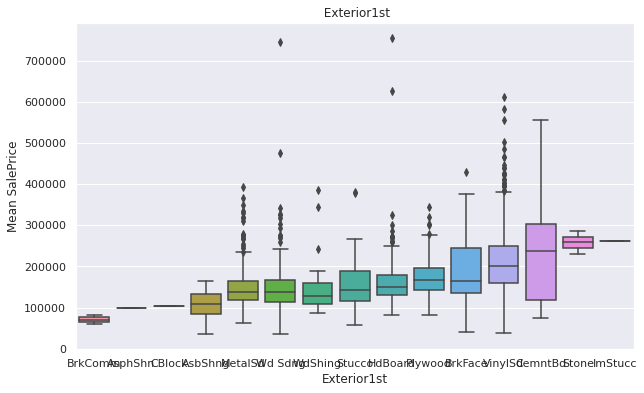

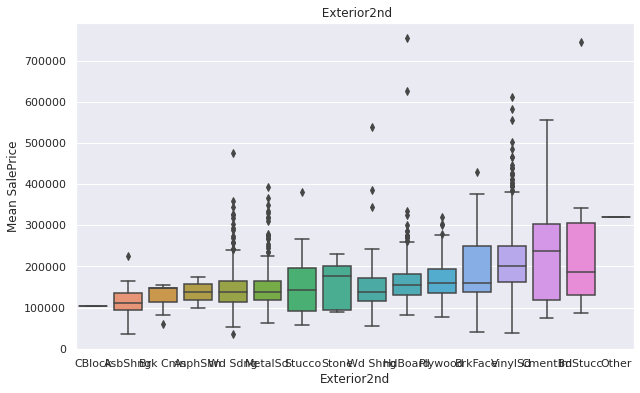

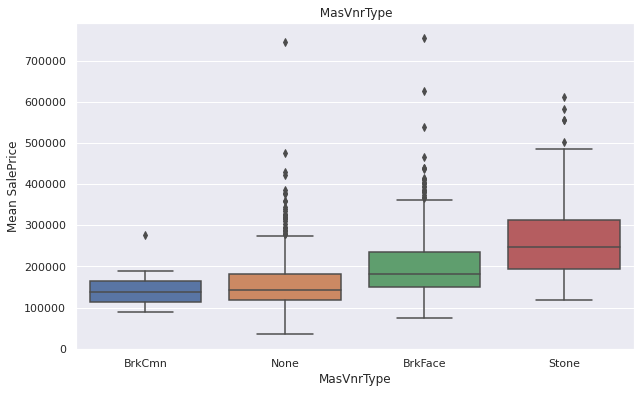

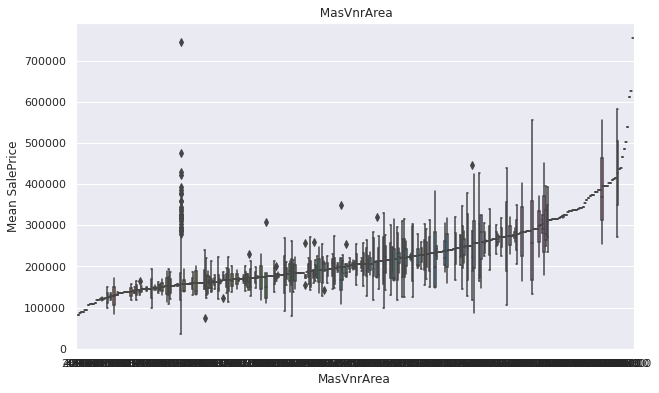

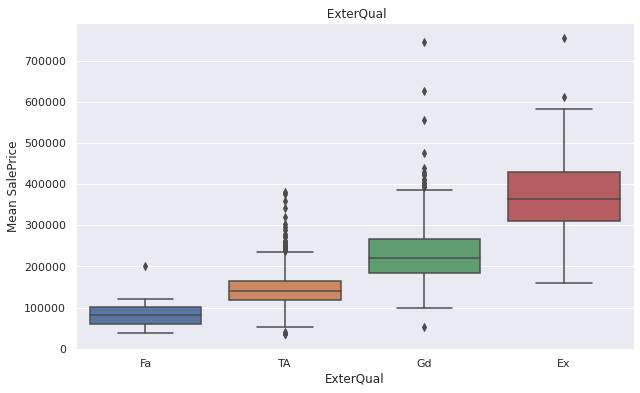

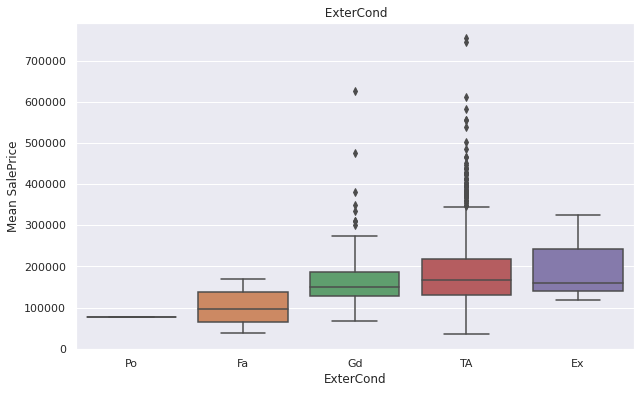

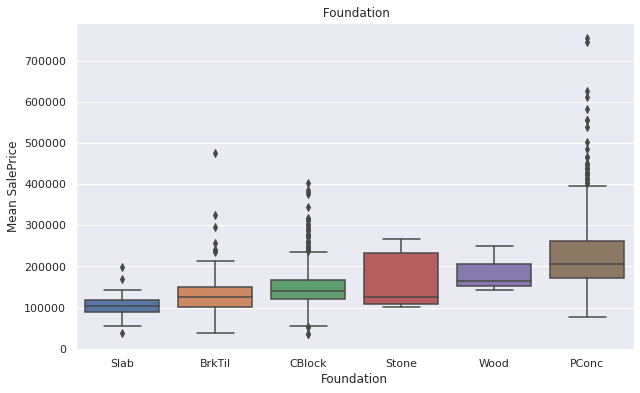

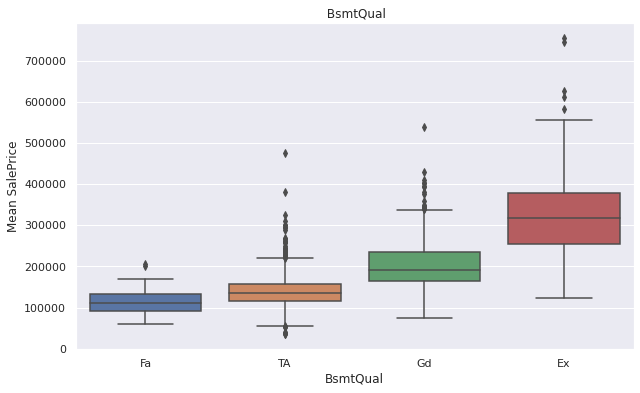

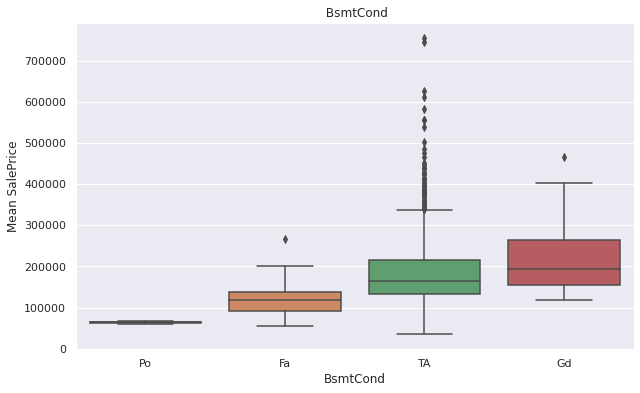

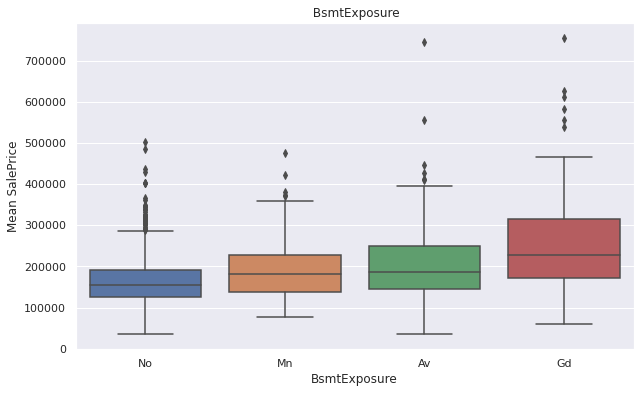

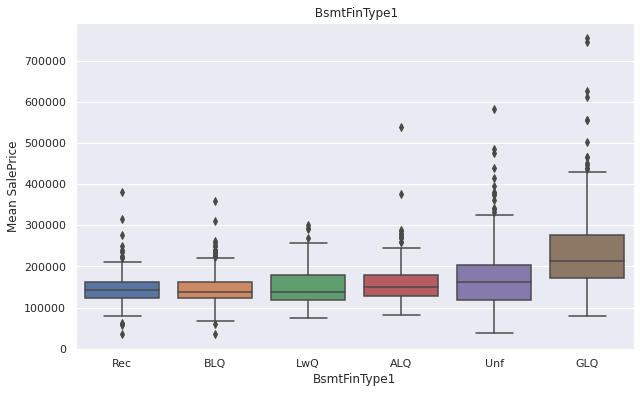

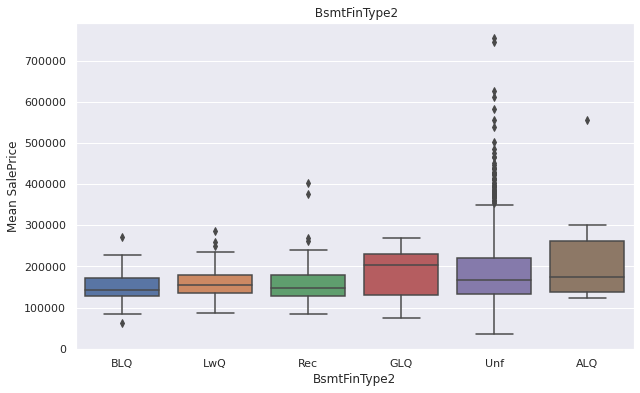

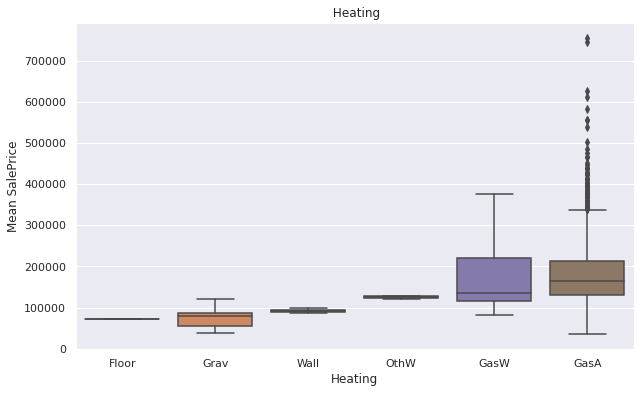

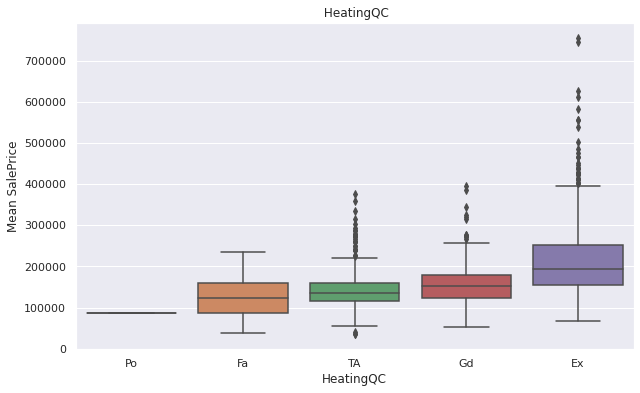

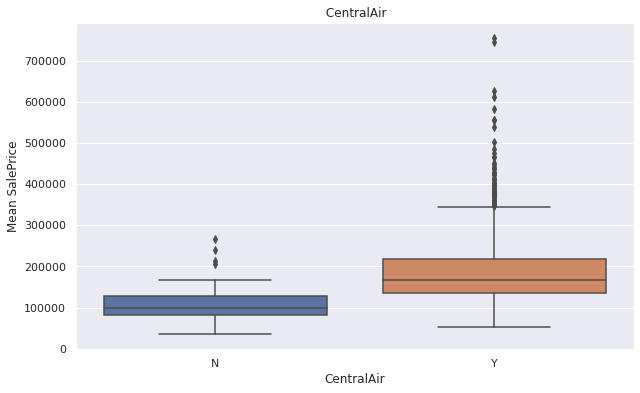

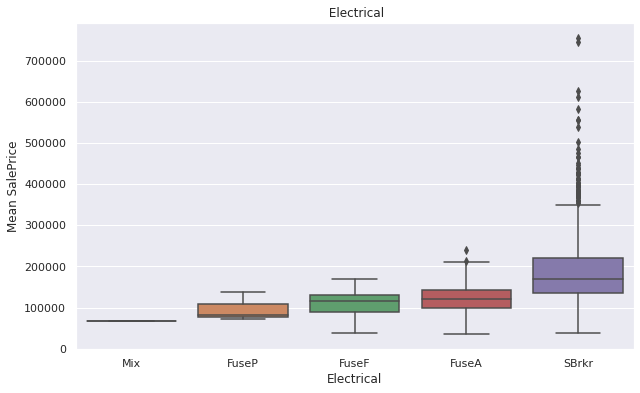

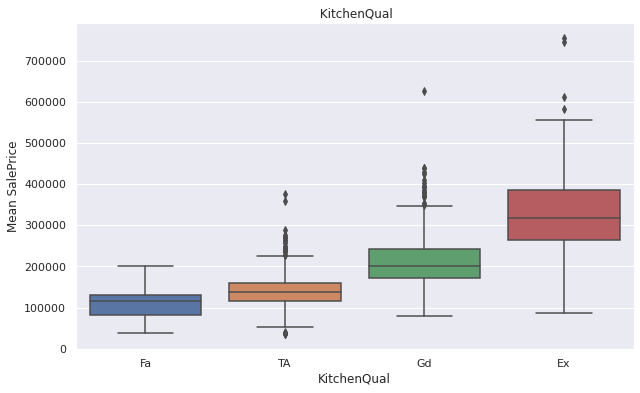

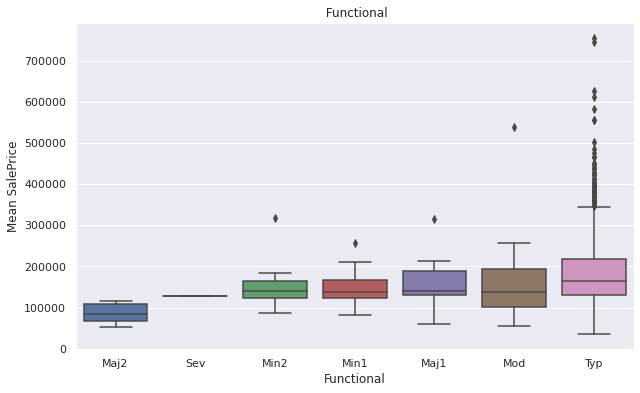

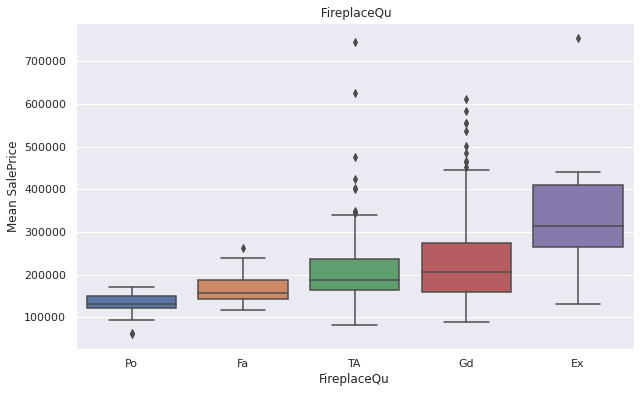

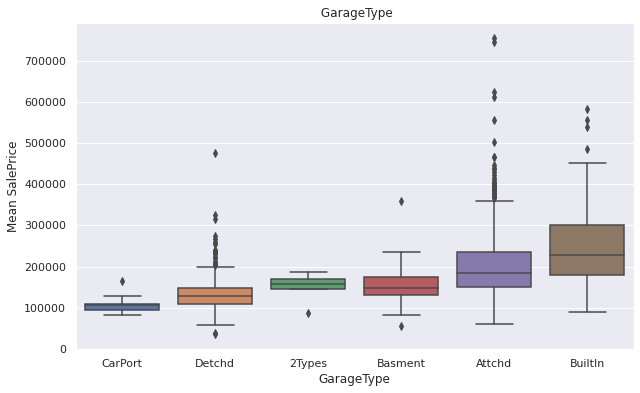

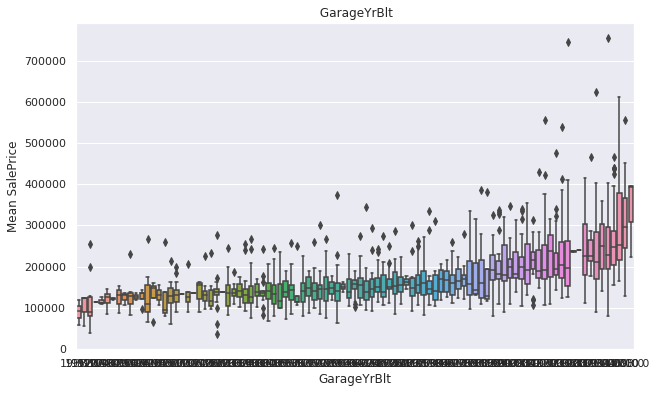

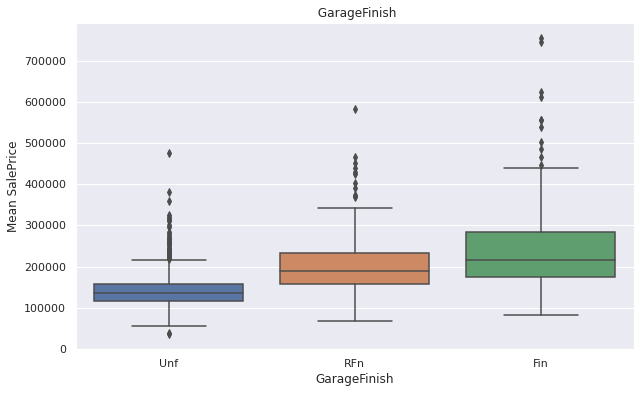

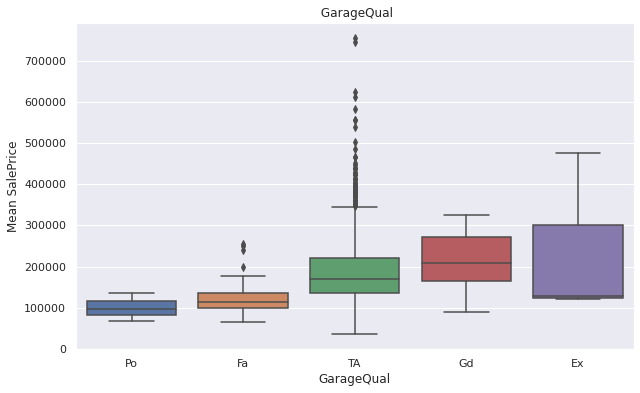

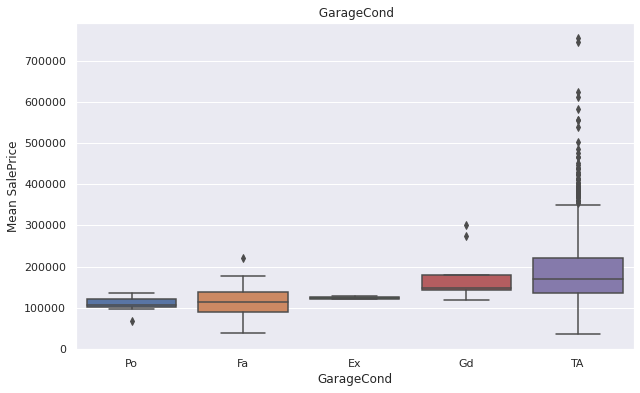

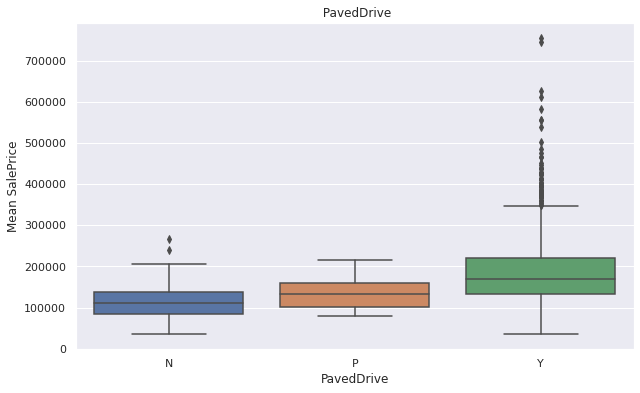

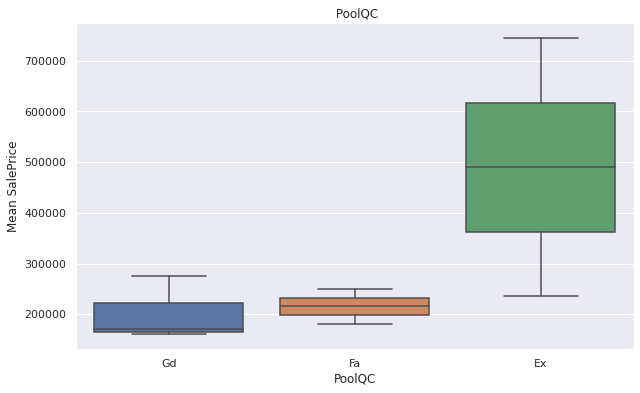

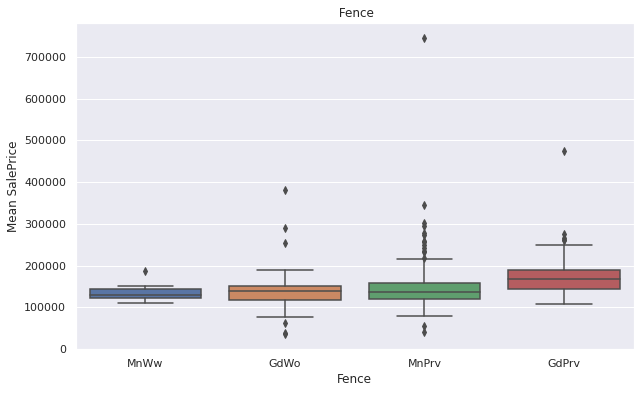

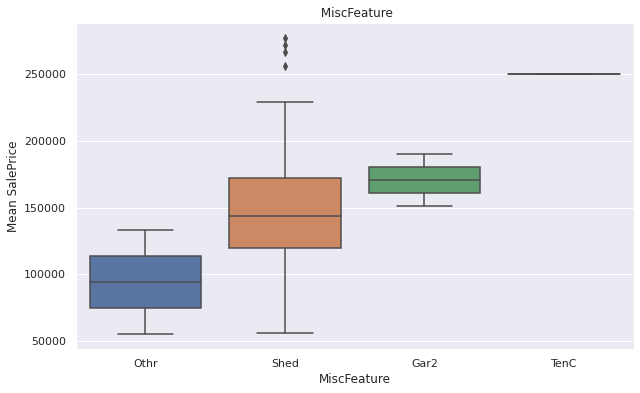

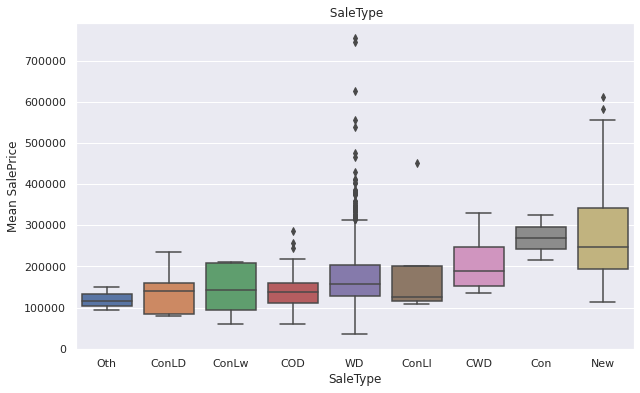

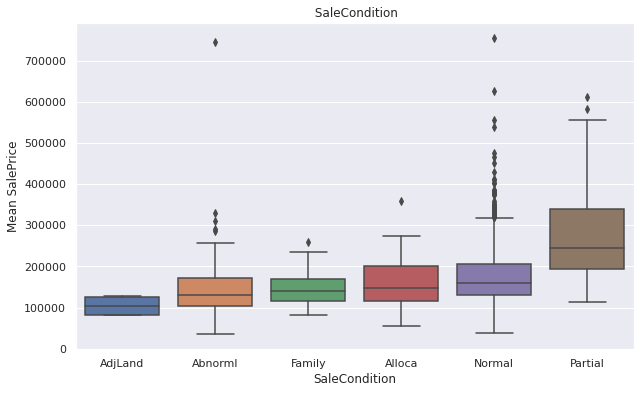

In [27]:
plt.rcParams.update({'figure.max_open_warning': 0})
i=1
while (i<46):
    cols=listcol[i]
    plt.figure(figsize=(10,6))
    cat_box(cols,df_train)
    i=i+1
        

### Missing Values

In [28]:
#Concatenate train and test data for handling missing data
nrows_train=df_train.shape[0]
nrows_test=df_test.shape[0]
target_var=df_train['SalePrice']
comb_data=pd.concat([df_train,df_test]).reset_index(drop=True)
comb_data.drop(['SalePrice'],axis=1,inplace=True)
print("Concatenated data size:{}".format(comb_data.shape))

Concatenated data size:(2919, 80)


In [29]:
nrows_train

1460

In [30]:
#Check for missing values in test data
data_missing=comb_data.isnull().sum().sort_values(ascending=False)
percent=(comb_data.isnull().sum() / comb_data.values.shape[0]).sort_values(ascending=False)
miss_data=pd.concat([data_missing,percent],axis=1,join='inner',keys=["Count","Percentage"])
miss_data.head(30)

,Count,Percentage
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [31]:
miss_data.shape

(80, 2)

In [32]:
miss_data.index.values

array(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'LotFrontage', 'GarageCond', 'GarageQual', 'GarageYrBlt',
       'GarageFinish', 'GarageType', 'BsmtCond', 'BsmtExposure',
       'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType',
       'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Utilities',
       'Functional', 'BsmtFullBath', 'BsmtFinSF1', 'Exterior1st',
       'Exterior2nd', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'SaleType', 'Electrical', 'KitchenQual', 'GarageArea',
       'GarageCars', 'HouseStyle', 'LandSlope', 'MSSubClass', 'LotArea',
       'Street', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'OverallQual', 'Condition1', 'Condition2', 'RoofMatl', 'RoofStyle',
       'BldgType', 'YearRemodAdd', 'YearBuilt', 'OverallCond',
       'SaleCondition', 'Heating', 'ExterQual', 'ExterCond', 'YrSold',
       'MoSold', 'MiscVal', 'PoolArea', 'ScreenPorch', '3SsnPorch',
       'EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF', 'PavedDriv

### Handling Missing Data

In [33]:
#Define a functions to handle missing data
def fill_none(feature,df):
    df[feature]=df[feature].fillna("None")
    
fillnone_cols=['PoolQC','MiscFeature', 'Alley', 'Fence', 'FireplaceQu','GarageCond', 'GarageFinish',
              'GarageType', 'BsmtCond','BsmtQual', 'BsmtFinType2', 'BsmtFinType1','GarageQual',
              'MasVnrType','BsmtExposure']
i=0
while (i<15):
    fill_none(fillnone_cols[i],comb_data)
    i=i+1
    


In [34]:
def fill_0(feature,df):
    df[feature]=df[feature].fillna(0)
    
    
fill0_cols=['MasVnrArea','GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
             'TotalBsmtSF','BsmtFullBath','BsmtHalfBath']

i=0
while (i<10):
    fill_0(fill0_cols[i],comb_data)
    i=i+1

In [35]:

def fill_mode(feature,df):
    df[feature]=df[feature].fillna(df[feature].mode()[0])
      
fillmode_cols=['MSZoning','Electrical','SaleType','Exterior1st','Exterior2nd','KitchenQual']

i=0
while (i<6):
    fill_mode(fillmode_cols[i],comb_data)
    i=i+1


In [36]:
comb_data["LotFrontage"]=comb_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x:x.fillna(x.median()))

In [37]:
comb_data=comb_data.drop("Utilities",axis=1)

In [38]:
comb_data["Functional"]=comb_data["Functional"].fillna("typ")

In [39]:
comb_data.isnull().sum().sort_values(ascending=False)

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
                ..
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
Id               0
Length: 79, dtype: int64

> > > > > > > 

# Part 3 - DEVELOP

## Create the model

In [40]:
from sklearn.linear_model import ElasticNet,Lasso,BayesianRidge,LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error


In [41]:
new_data=pd.get_dummies(comb_data)
new_data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0


In [42]:
new_data.shape

(2919, 302)

In [43]:
#Shuffle and reindex data
new_data=shuffle(new_data).reset_index()

In [44]:
#Seperate training and test set from comb data
train_model_input=new_data[:1460]
train_model_output=df_train['SalePrice']
train_model_log_output=np.log1p(df_train['SalePrice']).values
test_model_data=new_data[1460:]

In [45]:
inputdata=new_data[:1460]
testdata=new_data[1460:]
outputdata=np.log1p(df_train['SalePrice']).values


In [46]:
train_model_input.shape,train_model_output.shape,train_model_log_output.shape,test_model_data.shape

((1460, 303), (1460,), (1460,), (1459, 303))

## Linear Regression

In [47]:
lr=LinearRegression()

In [48]:
#Cross Validation on train data
n_folds=5
kf=KFold(n_folds,shuffle=False,random_state=None).get_n_splits(train_model_input,train_model_output)
rmse=np.sqrt(-cross_val_score(lr,train_model_input,train_model_output,scoring="neg_mean_squared_error",cv=kf))
print(rmse)
mean=rmse.mean()
print("Root mean squared error is {}".format(mean))

[4.23024308e+08 2.32633122e+08 9.93032145e+04 1.05316653e+09
 2.10941974e+08]
Root mean squared error is 383973048.26582015


## Random Forest Regressor

In [49]:
rfr=RandomForestRegressor(max_depth=25)
n_folds=5
kf=KFold(n_folds,shuffle=True,random_state=12).get_n_splits(train_model_input,train_model_output)
rmse=np.sqrt(-cross_val_score(rfr,train_model_input,train_model_output,scoring="neg_mean_squared_error",cv=kf))
print(rmse)
print("Root mean squared error is {}".format(rmse.mean()))


[76224.34503669 85343.5968015  88999.90335094 74615.31836828
 84379.58443032]
Root mean squared error is 81912.54959754692


## Gradient Boosting Regressor

In [50]:
gbr=GradientBoostingRegressor()
n_folds=5
kf=KFold(n_folds,shuffle=True,random_state=12).get_n_splits(train_model_input,train_model_output)
rmse=np.sqrt(-cross_val_score(lr,train_model_input,train_model_output,scoring="neg_mean_squared_error",cv=kf))
print(rmse)
print("Root mean squared error is {}".format(rmse.mean()))

[4.23024308e+08 2.32633122e+08 9.93032145e+04 1.05316653e+09
 2.10941974e+08]
Root mean squared error is 383973048.26582015


## Elastic Net Regression

In [51]:
en=ElasticNet()
n_folds=5
kf=KFold(n_folds,shuffle=True,random_state=12).get_n_splits(train_model_input,train_model_output)
rmse=np.sqrt(-cross_val_score(en,train_model_input,train_model_output,scoring="neg_mean_squared_error",cv=kf))
print(rmse)
print("Root mean squared error is {}".format(rmse.mean()))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3553899015245.4375, tolerance: 759214014.2531197
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3405567542351.329, tolerance: 728773513.025937
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3321921958936.787, tolerance: 699031751.5199751
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360645792255

[75102.4719029  87350.29254269 87818.96139775 73586.09988015
 83215.85851185]
Root mean squared error is 81414.7368470685


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3380218021517.2134, tolerance: 724930391.3116124
  positive)


## Lasso Regression

In [52]:
las=Lasso()
n_folds=5
kf=KFold(n_folds,shuffle=True,random_state=12).get_n_splits(train_model_input.values)
rmse=np.sqrt(-cross_val_score(las,train_model_input.values,train_model_output,scoring="neg_mean_squared_error",cv=kf))
print(rmse)
print("Root mean squared error is {}".format(rmse.mean()))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3202454062453.208, tolerance: 759214014.2531197
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2955756411624.616, tolerance: 728773513.025937
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2787843770318.4263, tolerance: 699031751.5199751
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319048645048

[ 79661.25285416 103354.24559297  99139.22778864  81972.56858499
  88997.978458  ]
Root mean squared error is 90625.05465575153


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2967523917660.52, tolerance: 724930391.3116124
  positive)


## BayesianRidge

In [53]:
br=BayesianRidge()
n_folds=5
kf=KFold(n_folds,shuffle=True,random_state=12).get_n_splits(train_model_input.values)
rmse=np.sqrt(-cross_val_score(br,train_model_input.values,train_model_output,scoring="neg_mean_squared_error",cv=kf))
print(rmse)
print("Root mean squared error is {}".format(rmse.mean()))

[74389.25654113 81100.35952946 87170.56321579 71848.34744943
 81903.12797849]
Root mean squared error is 79282.3309428574


So RandomForest Regressor is the best model

In [54]:
#train model on entire data set
rfr.fit(inputdata,train_model_output)



RandomForestRegressor(max_depth=25)

In [55]:
#Create Predictions based on train data
predictions=rfr.predict(new_data[:1460])

In [56]:
testdata.shape

# test data is an input data set which does not have the ooutput prediction. You can only compare your output with a 
# known value . So you cannot use this for MSE. MSE compares between 2 known values. in the below script you 
# are comparing input data set with predictions, input data set 

(1459, 303)

In [57]:
MSE=mean_squared_error(train_model_output,predictions)
MSElog=mean_squared_error(np.log(train_model_output),np.log(predictions))
MSE,MSElog

(1115997546.9438286, 0.03834577376996293)

In [58]:
#Fit model on log data
rfr_log=RandomForestRegressor()
log_output=np.log(train_model_output)


In [60]:
rfr_log.fit(inputdata,log_output)
log_predictions=rfr_log.predict(new_data[:1460])

In [61]:
#Predict test data
log_test_predictions=rfr_log.predict(testdata)


In [62]:
log_predictions.shape

(1460,)

In [63]:
MSEL=mean_squared_error(np.exp(log_output),np.exp(log_predictions))
MSELlog=mean_squared_error(log_output,log_predictions)
MSEL,MSELlog

(1292859114.505237, 0.02375549552111815)

In [64]:
log_test_predictions_df=pd.DataFrame(log_test_predictions)

In [65]:
type(log_test_predictions)
print(log_test_predictions.shape)
pd.Series(np.expm1(log_test_predictions)).shape
#pd.concat([testids,pd.Series(np.expm1(log_predictions))],axis=1)

(1459,)


(1459,)

In [66]:
log_test_predictions

array([12.07187076, 11.9867642 , 11.98212381, ..., 11.99427754,
       11.98729133, 12.03320659])

In [67]:
#log_test_predictions_df.to_csv('../working/submissions_1.csv',index=False)

In [68]:
testids=df_test['Id']

In [69]:
testids

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [70]:
#
testdata
log_test_predictions
results=[]

In [71]:
results=pd.concat([testids,pd.Series(np.expm1(log_test_predictions))],axis=1,keys=['Id','SalePrice'])

In [ ]:
#kaggle competitions submit -c house-prices-advanced-regression-techniques -f submissions_1.csv -m "My first Sub"

In [72]:
results

,Id,SalePrice
0,1461,174881.703708
1,1462,160613.795036
2,1463,159870.206496
3,1464,150328.661139
4,1465,159723.913692
...,...,...
1454,2915,167285.702092
1455,2916,142381.539825
1456,2917,161825.092753
1457,2918,160698.482616


In [73]:
results.to_csv('../working/submissions_10.csv',index=False)

In [74]:
results.tail

<bound method NDFrame.tail of         Id      SalePrice
0     1461  174881.703708
1     1462  160613.795036
2     1463  159870.206496
3     1464  150328.661139
4     1465  159723.913692
...    ...            ...
1454  2915  167285.702092
1455  2916  142381.539825
1456  2917  161825.092753
1457  2918  160698.482616
1458  2919  168249.057202

[1459 rows x 2 columns]>